# Task 2b: Attribute Classification (Mounting Type)

**Student:** Stefania Livori  
**Student ID:** 0269305L    
**Model:** Faster R-CNN (ResNet50 FPN)

This notebook implements a detector specifically for classifying the mounting type of traffic signs. It covers:
1.  **Dataset Preparation**: Custom `MountingDataset` parsing "mounting" attributes.
2.  **Model Training**: Training to detect and classify 'Pole-mounted' vs 'Wall-mounted'.
3.  **Evaluation**: Calculating F1-Scores.
4.  **Inference & Analytics**: Visualisation and counting detections of mounting types.

In [13]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
from stefania_livori_utils import *

# Ensure reproducible results
torch.manual_seed(42)

## 1. Dataset Preparation

I extract the zip file to get the images from the file named `merged_images.zip` if not already present. Afterwards I change the json format to COCO format and save it to `merged_coco.json`. This was done since Faster R-CNN prefers COCO format.

In [14]:
unzip_folder("merged_images.zip", "merged_images")


I define the `MountingDataset` class. This class parses the Label Studio JSON export to extract the "mounting" attribute for each sign.     
**Handling Robustness:** This correctly handles images with multiple signs having different mounting types by checking for linked IDs (`from_id`).

In [15]:
# Update paths
DATA_DIR = "merged_images" 
ANNOTATION_FILE = "merged_input.json"

In [16]:
# Mounting Classes mapping
MOUNTING_CLASSES = {
    1: "Pole-mounted",
    2: "Wall-mounted"
}

NUM_CLASSES = len(MOUNTING_CLASSES) + 1 # +1 for background

class MountingDataset(Dataset):
    # root - folder containing images
    # ann_file - Label Studio JSON export
    # transforms - image preprocessing
    # preload - load images into memory for faster training
    def __init__(self, root, ann_file, transforms=None, preload=True):
        self.root = root

        print(f"Loading annotations from {ann_file}")
        print(f"Images root directory: {root}")
        
        self.transforms = transforms

        # Load the annotations
        with open(ann_file) as f:
            self.tasks = json.load(f)

        self.preload = preload
        # Preload images into memory for faster training
        if preload:
            self.loaded_images = []
            for task in self.tasks:
                img_rel_path = task["file_upload"]
                img_path = os.path.join(self.root, img_rel_path)

                try:
                    with Image.open(img_path) as img:
                        self.loaded_images.append(img.convert("RGB").copy())
                except FileNotFoundError:
                    print(f"Warning: Image not found {img_path}")

    def __getitem__(self, idx):
        task = self.tasks[idx]

        if self.preload:
            img = self.loaded_images[idx].copy()
        else:
            if "data" in task and "image" in task["data"]:
                img_rel_path = task["file_upload"]
                img_path = os.path.join(self.root, img_rel_path)
            else:
                 img_path = ""
            if os.path.exists(img_path):
                img = Image.open(img_path).convert("RGB")
            else:
                print(f"Warning: Image not found {img_path}")
        # Load the bounding boxes and labels
        boxes, labels = [], []

        if "annotations" in task:
            for ann in task["annotations"]:
                # Robust parsing for multiple objects/attributes
                # id -> rect_info
                rect_map = {}    
                # rect_id -> mount_class
                mount_map = {}    
                global_mount = None

                if "result" in ann:
                    # Pass 1: Gather all regions and choices
                    for r in ann["result"]:
                        rid = r.get("id")
                        
                        if r["type"] == "rectanglelabels":
                            rect_map[rid] = r
                        
                        elif r["from_name"] == "mounting":
                            if "value" in r and "choices" in r["value"] and len(r["value"]["choices"]) > 0:
                                val = r["value"]["choices"][0]
                                mount_label = MOUNTING_CLASSES.get(val, None)
                                
                                if mount_label is not None:
                                    # Check linkage via from_id
                                    if "from_id" in r:
                                        mount_map[r["from_id"]] = mount_label
                                    else:
                                        # Fallback to global if not linked
                                        global_mount = mount_label
                
                    # Pass 2: Generate prediction targets
                    iw, ih = img.size
                    for rid, r in rect_map.items():
                        # Priority: Specific Link > Global Fallback
                        m = mount_map.get(rid, global_mount)
                        
                        if m is not None:
                            x = r["value"]["x"]
                            y = r["value"]["y"]
                            w = r["value"]["width"]
                            h = r["value"]["height"]
                            
                            boxes.append([
                                x/100*iw, y/100*ih,
                                (x+w)/100*iw, (y+h)/100*ih
                            ])
                            labels.append(m)
                            
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            # Converted to pytorch tensor
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.loaded_images)

### Initialize Dataset and DataLoaders

In [17]:
transform = T.Compose([T.ToTensor()])

dataset = MountingDataset(
    root=DATA_DIR,
    ann_file=ANNOTATION_FILE,
    transforms=transform
)

# Expected 710
# print(f"Total dataset size: {len(dataset)}")

# Split dataset
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=lambda x: tuple(zip(*x)))

val_loader = DataLoader(
    val_dataset, 
    batch_size=2, 
    shuffle=False, 
    collate_fn=lambda x: tuple(zip(*x)))

Loading annotations from merged_input.json
Images root directory: merged_images
Training set size: 568
Validation set size: 142


## 2. Model Configuration

In [18]:
device = get_device()
model = get_faster_rcnn(NUM_CLASSES).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Might need to try different step sizes
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.1
)

Using device: cuda


## 3. Training Loop

Training for 20 epochs and evaluating on validation set after each epoch.

In [19]:
num_epochs = 1
train_losses = []
val_f1_scores = []
train_cls_losses = []
train_box_losses = []

for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    losses = train_one_epoch(model, train_loader, optimizer, device)
    
    train_losses.append(losses["total"])
    train_cls_losses.append(losses["cls"])
    train_box_losses.append(losses["box"])
    scheduler.step()

    f1 = f1_score_by_iou(model, val_loader, device)
    val_f1_scores.append(f1)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Total Loss: {losses['total']:.4f} | "
        f"Cls Loss: {losses['cls']:.4f} | "
        f"Box Loss: {losses['box']:.4f} | "
        f"F1: {f1:.4f}"
    )


Starting Epoch 1/1


AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

### Plotting the losses for the mounting type

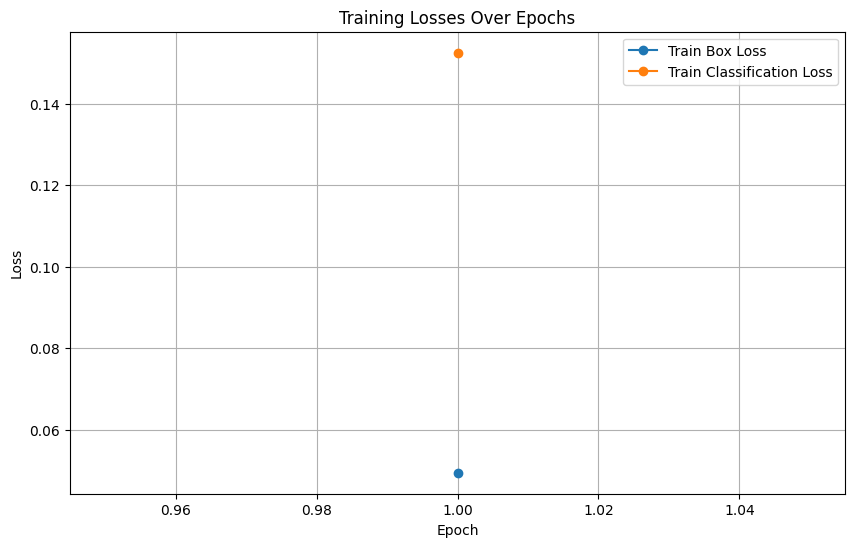

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs + 1), train_box_losses,
         label='Train Box Loss', marker='o')

plt.plot(range(1, num_epochs + 1), train_cls_losses,
         label='Train Classification Loss', marker='o')

plt.title("Training Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Plotting the F1-score for each epoch

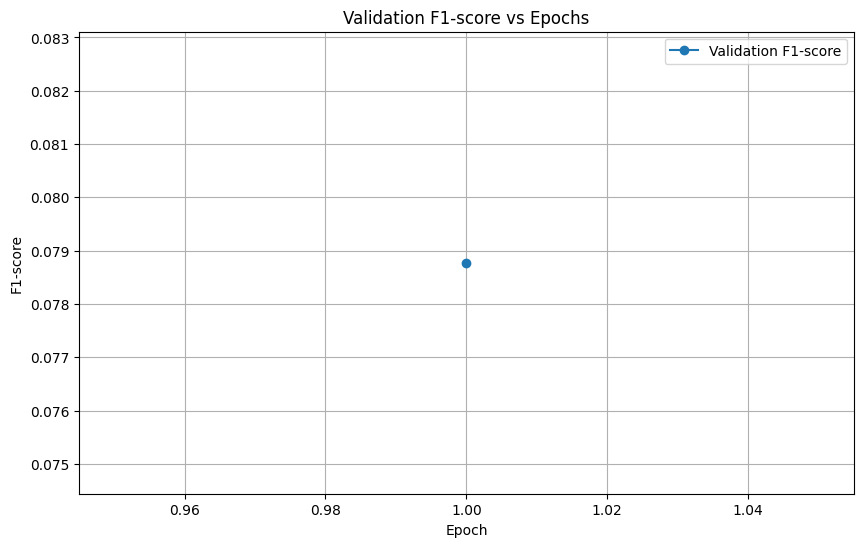

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(
    epochs,
    val_f1_scores,
    marker="o",
    linestyle="-",
    label="Validation F1-score"
)

plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Validation F1-score vs Epochs")
plt.grid(True)
plt.legend()
plt.show()


## 4. Analytics & Visualization

In [ ]:
model.eval()

total_detected_signs = 0
results_summary = []

with torch.no_grad():
    for img, target in val_dataset:
        prediction = model([img.to(device)])[0]
        
        keep = prediction["scores"] > 0.5
        final_boxes = prediction["boxes"][keep]
        final_labels = prediction["labels"][keep]
        final_scores = prediction["scores"][keep]
        
        count = len(final_labels)
        total_detected_signs += count
        
        results_summary.append({
            "ImageID": target["image_id"].item(),
            "DetectedSigns": count,
            "Labels": [MOUNTING_CLASSES.get(l.item(), "Unknown") for l in final_labels]
        })

print(f"Total signs detected in validation set: {total_detected_signs}")
print("Results summary:")
for res in results_summary:
    print(res)

Detected Mounting Types Distribution:
Pole-mounted: 0
Wall-mounted: 0


### Plot of F1-Score vs Confidence Threshold

Threshold: 0.10, F1 Score: 0.0788
Threshold: 0.15, F1 Score: 0.1075
Threshold: 0.20, F1 Score: 0.1163
Threshold: 0.25, F1 Score: 0.0417
Threshold: 0.30, F1 Score: 0.0000
Threshold: 0.35, F1 Score: 0.0000
Threshold: 0.40, F1 Score: 0.0000
Threshold: 0.45, F1 Score: 0.0000
Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.55, F1 Score: 0.0000
Threshold: 0.60, F1 Score: 0.0000
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000
Threshold: 0.95, F1 Score: 0.0000


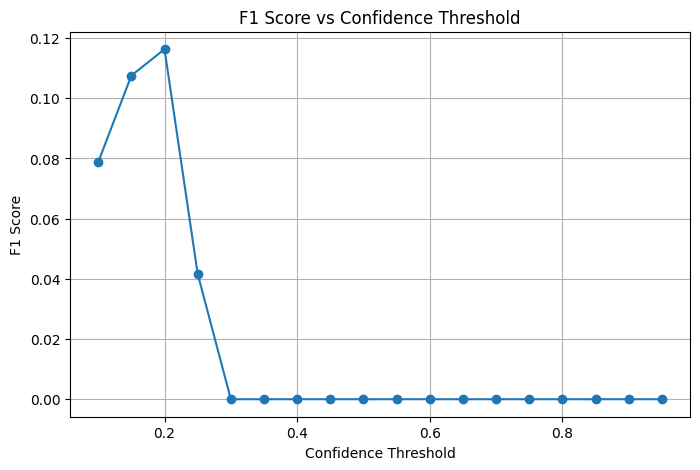

In [ ]:
import numpy as np

confidence_thresholds = np.linspace(0.1, 0.95, 18)

f1_val_scores = []
for thresh in confidence_thresholds:
    f1 = f1_score_by_iou(model, val_loader, device, iou_threshold=0.5, score_threshold=thresh)
    f1_val_scores.append(f1)
    print(f"Threshold: {thresh:.2f}, F1 Score: {f1:.4f}")

plt.figure(figsize=(8,5))
plt.plot(confidence_thresholds, f1_val_scores, marker='o')
plt.title("F1 Score vs Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


### Save the model

In [ ]:
torch.save(model.state_dict(), "./models/faster_rcnn_stefania_livori.pt")

### Qualitative results and Visualisation


Visualizing Sample Predictions:
Sample 1 GT: ['Pole-mounted', 'Pole-mounted']


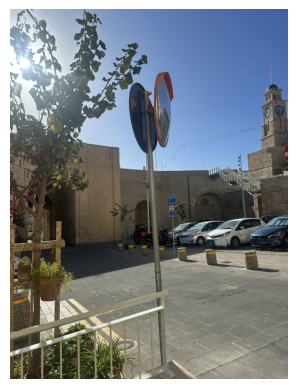

Sample 2 GT: ['Pole-mounted']


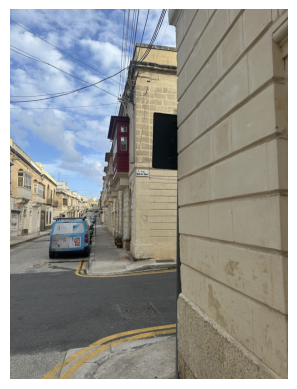

Sample 3 GT: ['Pole-mounted']


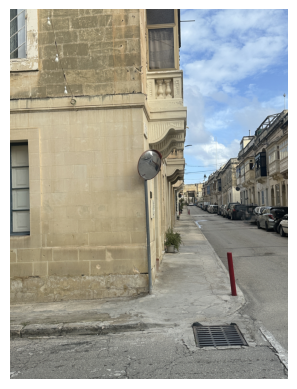

Sample 4 GT: ['Wall-mounted']


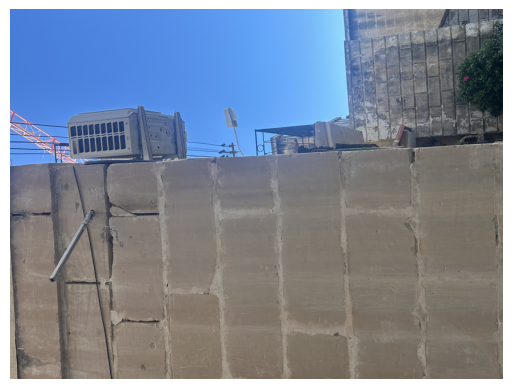

Sample 5 GT: ['Pole-mounted']


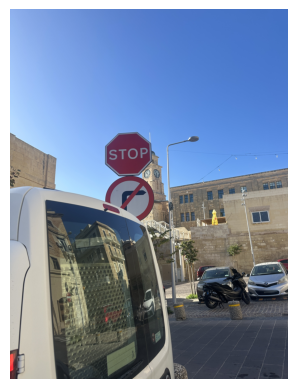

Sample 6 GT: ['Wall-mounted']


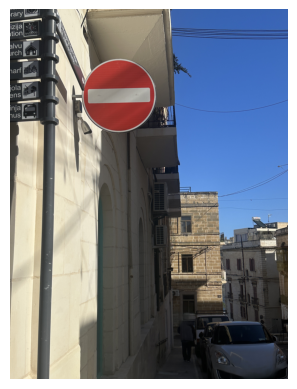

Sample 7 GT: ['Wall-mounted', 'Wall-mounted']


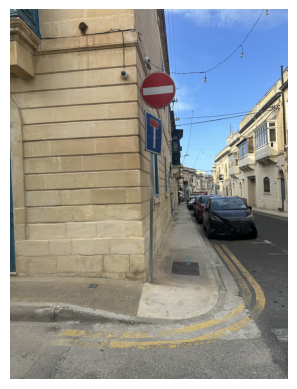

Sample 8 GT: ['Pole-mounted']


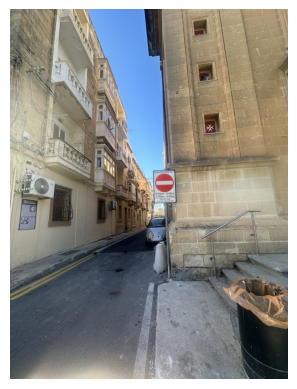

Sample 9 GT: ['Pole-mounted', 'Pole-mounted']


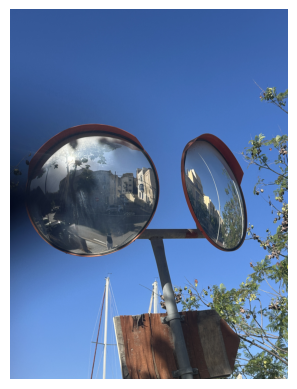

Sample 10 GT: ['Pole-mounted']


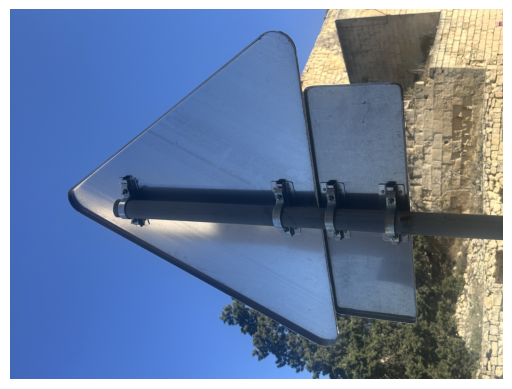

Sample 11 GT: ['Pole-mounted']


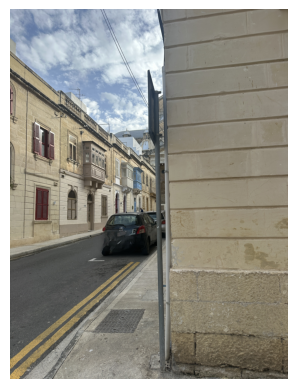

Sample 12 GT: ['Pole-mounted', 'Pole-mounted']


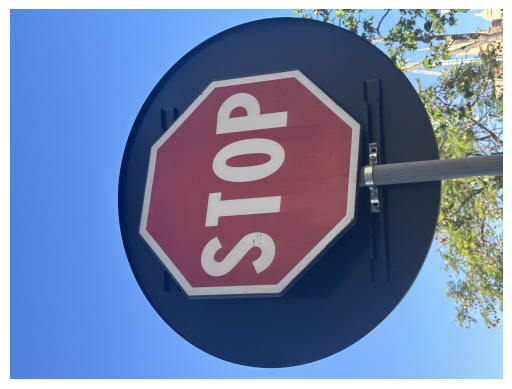

Sample 13 GT: ['Pole-mounted', 'Pole-mounted']


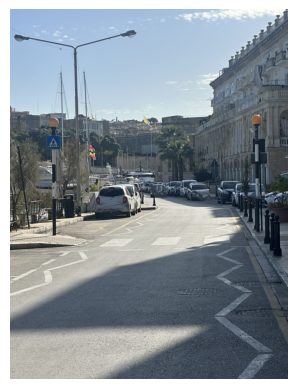

Sample 14 GT: ['Pole-mounted', 'Pole-mounted']


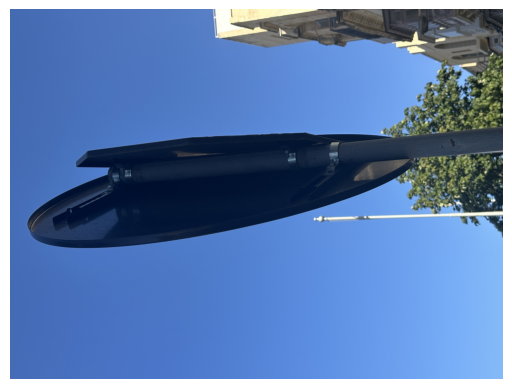

Sample 15 GT: ['Pole-mounted', 'Pole-mounted']


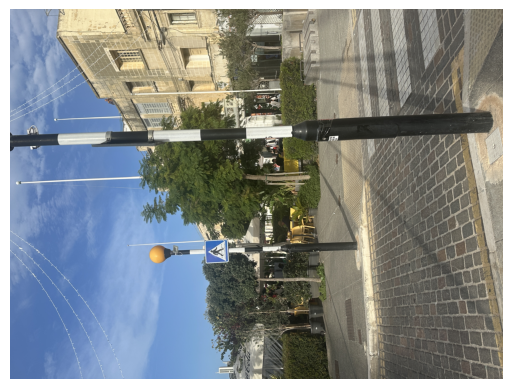

Sample 16 GT: ['Pole-mounted', 'Pole-mounted']


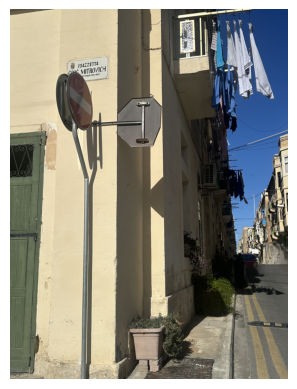

Sample 17 GT: ['Pole-mounted', 'Pole-mounted']


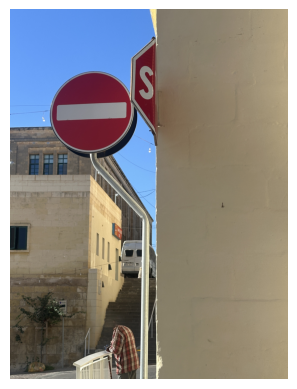

Sample 18 GT: ['Pole-mounted', 'Pole-mounted']


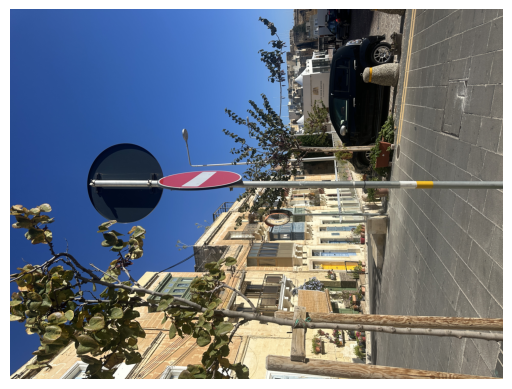

Sample 19 GT: ['Pole-mounted', 'Pole-mounted']


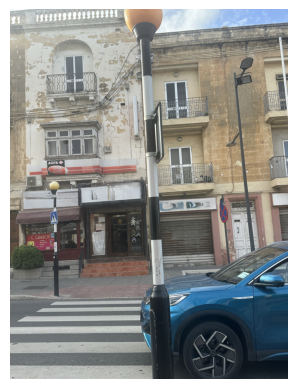

Sample 20 GT: ['Pole-mounted']


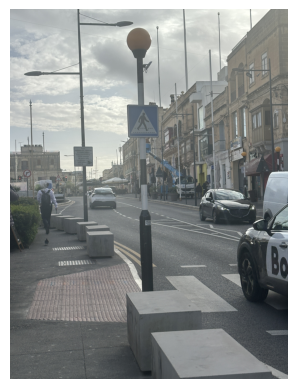

Sample 21 GT: ['Pole-mounted']


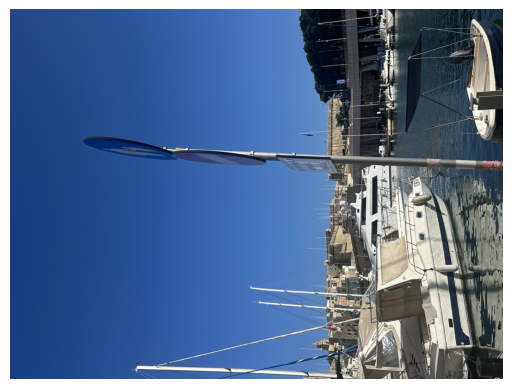

Sample 22 GT: ['Wall-mounted', 'Wall-mounted']


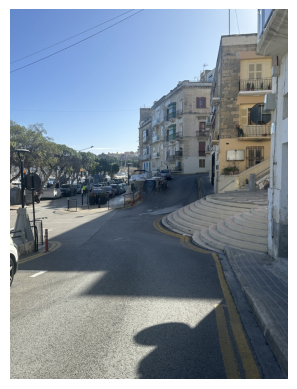

Sample 23 GT: ['Wall-mounted']


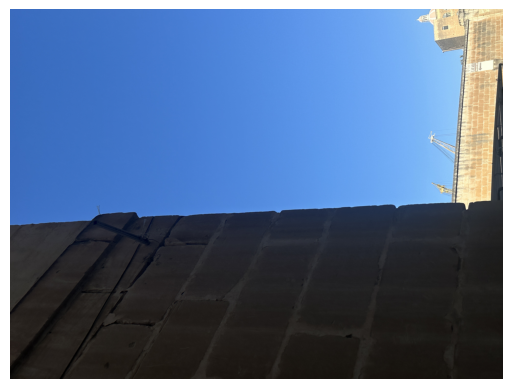

Sample 24 GT: ['Pole-mounted']


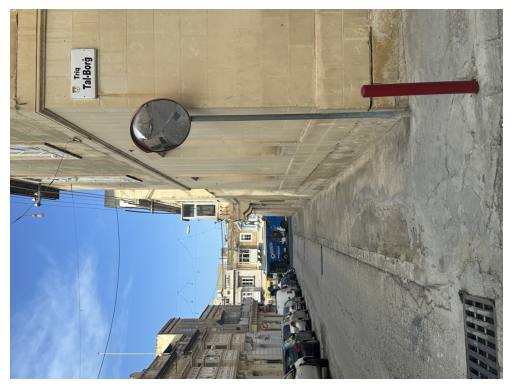

Sample 25 GT: ['Wall-mounted', 'Wall-mounted']


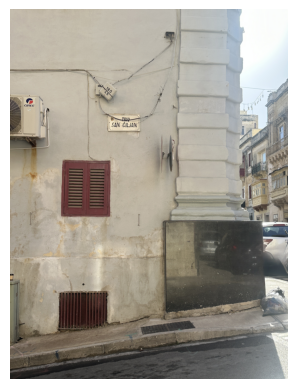

Sample 26 GT: ['Pole-mounted']


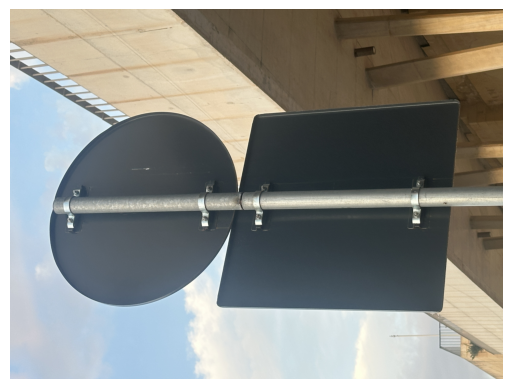

Sample 27 GT: ['Wall-mounted', 'Wall-mounted', 'Wall-mounted']


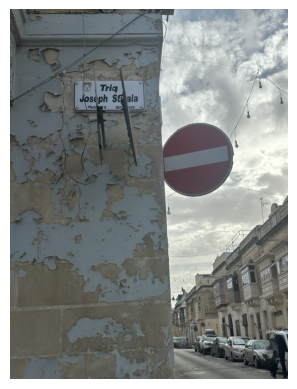

Sample 28 GT: ['Pole-mounted']


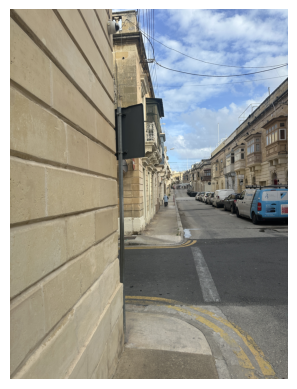

Sample 29 GT: ['Pole-mounted']


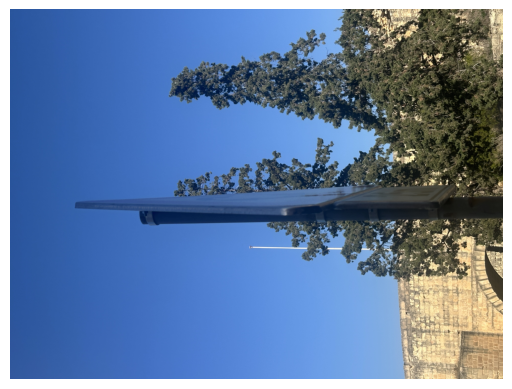

Sample 30 GT: ['Pole-mounted']


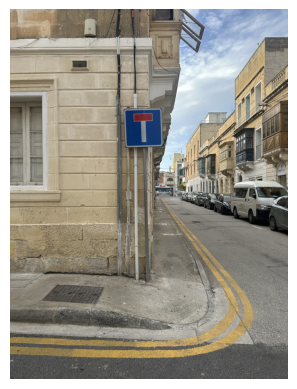

In [ ]:
print("\nVisualizing Sample Predictions:")
for i in range(len(val_ds)):
    img, target = val_ds[i]
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    gt_labels = [MOUNTING_CLASSES.get(l.item(), "Unknown") for l in target['labels']]
    print(f"Sample {i+1} Ground Truth: {gt_labels}")
    visualize_predictions(img, prediction, MOUNTING_CLASSES, threshold=0.5)

### Confusion Matrix over the validation set